# Image Colorization using Optimization

## Imports

In [1]:
%matplotlib inline

import sys
import numpy as np
import cv2
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

## Load Image

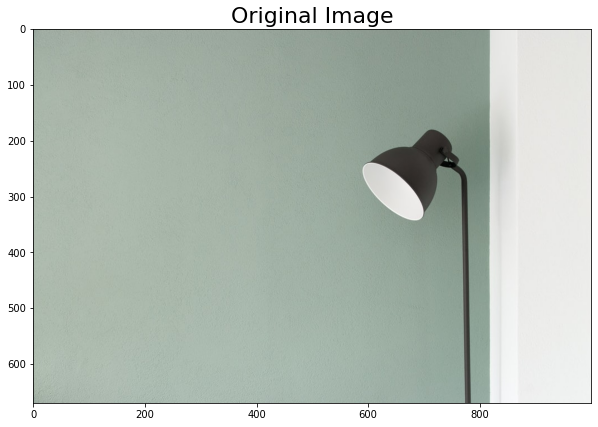

In [242]:
orig_img = cv2.cvtColor(cv2.imread("images/lamp.jpg"), cv2.COLOR_BGR2RGB)
plt.figure(figsize=(10, 10))
plt.title("Original Image", {'fontsize':22})
plt.imshow(orig_img)

## Convert to Grayscale

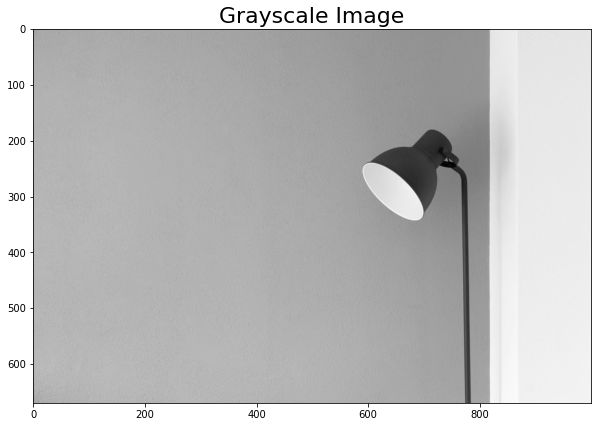

In [243]:
grayscale_img = cv2.cvtColor(orig_img, cv2.COLOR_RGB2GRAY)
plt.figure(figsize=(10, 10))
plt.title("Grayscale Image", {'fontsize':22})
plt.imshow(grayscale_img, cmap='gray')

## UI: Image Colorization Setup

### Step 1: Choose a color

In [176]:
from IPython import display
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual

color_picker = widgets.ColorPicker(
    concise=False,
    description='Pick a color',
    value='black',
    disabled=False
)
display.display(color_picker)

ColorPicker(value='black', description='Pick a color')

### Step 2: Place Markings

If it doesn't get you to the drawing mode, then rerun this function again.

============================================   NOTICE   ============================================

You do not need to rerun this cell or the last to add another color!
Simply select a new color from the color picker, press ENTER, and click on the figure to plot new colored points.


<IPython.core.display.Javascript object>


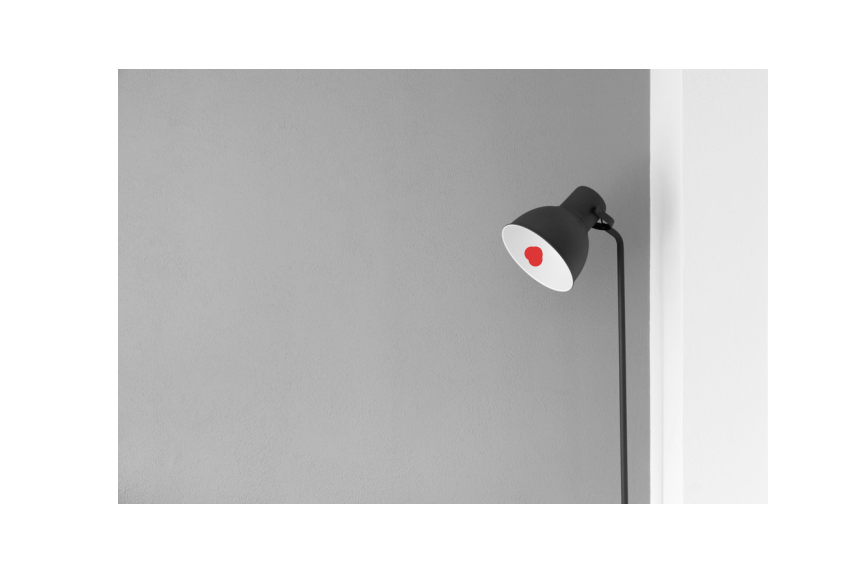

In [244]:
%matplotlib notebook

my_color = color_picker.value

def mark_image(img):
    print("If it doesn't get you to the drawing mode, then rerun this function again.")
    print("\n============================================   NOTICE   ============================================\n")
    print("You do not need to rerun this cell or the last to add another color!")
    print("Simply select a new color from the color picker, press ENTER, and click on the figure to plot new colored points.")
    fig = plt.figure()
    fig.set_label('Mark the spots to color')
    plt.axis('off')
    plt.imshow(img, cmap='gray')
    plot_points = []

    def on_mouse_pressed(event):
        my_color = color_picker.value
        
        x = event.xdata
        y = event.ydata
        plot_points.append((x, y, my_color))
        plt.plot(x, y, c=my_color, marker='o')
        
    # Create an hard reference to the callback not to be cleared by the garbage
    # collector
    fig.canvas.mpl_connect('button_press_event', on_mouse_pressed)

    return plot_points

plot_points = mark_image(grayscale_img)

### Step 3: Add Markings to grayscale image

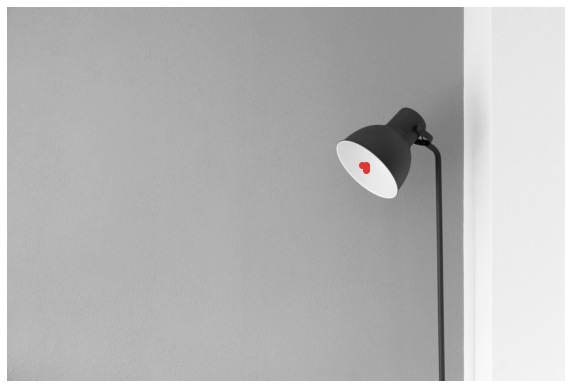

In [245]:
%matplotlib inline

plt.figure(figsize=(10, 10))
plt.axis('off')
plt.imshow(grayscale_img, cmap='gray')
for pt in plot_points:
    x, y, color = pt
    plt.plot(x, y, c=color, marker='o')
plt.savefig("output/marked_img.jpg", bbox_inches='tight', pad_inches=0, dpi=500)
marked_img = cv2.cvtColor(cv2.imread("output/marked_img.jpg"), cv2.COLOR_BGR2RGB)

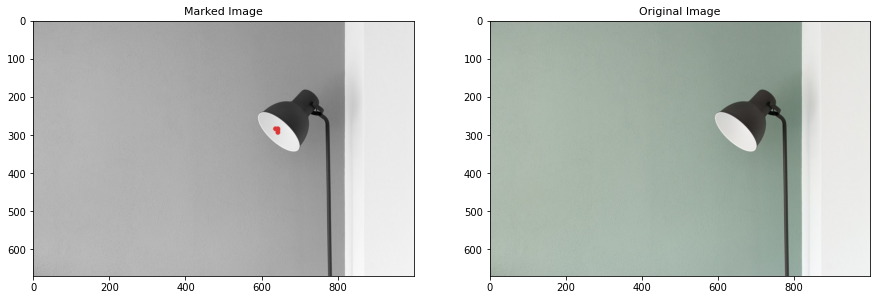

In [246]:
marked_img = cv2.resize(marked_img, (orig_img.shape[1], orig_img.shape[0]))

fig = plt.figure(figsize=(15, 15))
plt.subplot(122)
plt.title("Original Image", {'fontsize':11})
plt.imshow(orig_img)

plt.subplot(121)
plt.title("Marked Image", {'fontsize':11})
plt.imshow(marked_img)

In [247]:
def getWindowPixels(row, col):
    row_start = row - 1
    row_end = row + 2
    col_start = col - 1
    col_end = col + 2

    if row_start < 0:
        row_start = 0 
    if row_end >= height:
        row_end = height
    if col_start < 0:
        col_start = 0 
    if col_end >= width:
        col_end = width
    
    pixels = []
        
    for i in range(row_start, row_end):
        for j in range(col_start, col_end):
            if i != row or j != col:
                pixels.append((i, j))
                
    return pixels

## Calculate the variances and means for each pixel window

In [315]:
yuv_image = cv2.cvtColor(marked_img, cv2.COLOR_BGR2YUV)

variances = np.zeros((yuv_image.shape[0], yuv_image.shape[1]), dtype='uint8')
means = np.zeros(variances.shape, dtype='uint8')

height = variances.shape[0]
width = variances.shape[1]

# Calculate variances and mean for pixel windows
for row in range(height):
    if (row % 50 == 0):
        print("At row " + str(row))
    for col in range(width):       
        
        
        window = getWindowPixels(row, col)
        window_y_values = []
        
        for pixel in window:
            window_y_values.append(yuv_image[pixel[0], pixel[1]])
        
        variances[row, col] = np.var(window_y_values)
        means[row, col] = np.mean(window_y_values)
        

            

At row 0
At row 50
At row 100
At row 150
At row 200
At row 250
At row 300
At row 350
At row 400
At row 450
At row 500
At row 550
At row 600
At row 650


## Use the variances and means to calculate the weights for each pixel

In [ ]:
weights = {}

for row in range(height):
    if row % 10 == 0:
        print("Row: " + str(row))
    for col in range(width):
        neighboring_pixels = getWindowPixels(row, col)
        for pixel in neighboring_pixels:
            y_value = yuv_image[row, col, 0]
            
            weight = 1 + (1 / pow(variances[row, col], 2)) * (yuv_image[row, col, 0] - means[row, col]) * (yuv_image[row, col, 0] - means[pixel[0], pixel[1]])
            
            weights[((row, col), pixel)] = weight
            

### Normalize the weights

In [316]:
for row in range(height):
    for col in range(width):
        others = getWindowPixels(row, col)
        
        weightSum = 0
        
        for pixel in others:
            toAdd = weights[((row, col), (pixel[0], pixel[1]))]
            if math.isnan(toAdd):
                continue
            weightSum += weights[((row, col), (pixel[0], pixel[1]))]
            
        for pixel in others:
            weights[((row, col), (pixel[0], pixel[1]))] /= weightSum
            
# testList = getWindowPixels(171,250)


# for pixel in testList:
#     print(weights[(171, 250), (pixel[0], pixel[1])])


In [317]:
yuv_image = cv2.cvtColor(marked_img, cv2.COLOR_RGB2YUV)

yuv_image[300, 670, 1] = 13
yuv_image[300, 670, 2] = 13

print(yuv_image[200, 700, 0])
yuv_image[200, 700, 1] = 256
yuv_image[200, 700, 2] = 256

0.125
0.125
0.125
0.125
0.125
0.125
0.125
0.125
0.0
54


In [304]:
def traverseArea(start):
    toVisit = [start]
        
    while toVisit:
        point = toVisit.pop()
        
        if point in visited:
            continue
            
        visited.append(point)
        
        window = getWindowPixels(point[0], point[1])
    
        # Remove visited pixels
        for pixel in window:
            if pixel in visited:
                window.remove(pixel)

        minSize = 1 / len(getWindowPixels(point[0], point[1]))
        
        # Transfer color values
        variance_weights = []
        
        for pixel in window:
            weight = weights[((point[0], point[1]), (pixel[0], pixel[1]))]

            if math.isnan(weight):
#                 print('found nan')
                continue
                
            variance_weights.append(weight)
            
        neighbor_variance = np.var(variance_weights)
        
        for pixel in window:
            weight = weights[((point[0], point[1]), (pixel[0], pixel[1]))]

            if math.isnan(weight):
#                 print('found nan')
                continue
                
                
                
            if neighbor_variance < .0000005:
                yuv_image[pixel[0], pixel[1], 1] = yuv_image[point[0], point[1], 1]
                yuv_image[pixel[0], pixel[1], 2] = yuv_image[point[0], point[1], 2]
                toVisit.append(pixel) 
    
            if weight >= .65:
                print(weight)
                yuv_image[pixel[0], pixel[1], 1] = yuv_image[point[0], point[1], 1]
                yuv_image[pixel[0], pixel[1], 2] = yuv_image[point[0], point[1], 2]
                toVisit.append(pixel)  


visited = []
start = (238, 639)
traverseArea((300, 670))

In [318]:
traverseArea((200, 700))

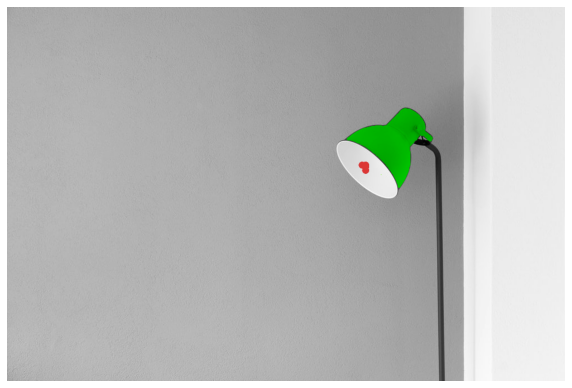

In [319]:
plt.figure(figsize=(10, 10))
plt.axis('off')
plt.imshow(cv2.cvtColor(yuv_image, cv2.COLOR_YUV2RGB))


In [191]:
print(yuv_image[250, 171])

[163 128 128]
